In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback, TypeNumberCallback,
)
from lib.sde.grn.grn import GRNMain
from lib.sde.mutate import SparseMutator

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model
from lib.utils import normalize_time, align_time
from jf.utils.helper import provide_id

In [5]:
NAME = "output/opti_metaparam_1"

In [9]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        _MUTATE_FUNC(self.grn)

In [6]:
exp = Exporter(NAME)

Exporting at output/opti_metaparam_1


In [11]:
g = exp.load('decay_temp_param_0.0_4')

In [18]:
g[-5].fit

9888.205009276437

In [22]:
def parse_name(x):
    return x.rsplit("_", maxsplit=2)

def get_score(x):
    return max([y.fit for y in x[950:1000]])

In [23]:
results = []
for sample in exp.list():
    sample_name, param_value, id_ = parse_name(sample)
    g = exp.load(sample)
    if len(g) < 1001:
        print("Problem with sample", len(g))
    score = get_score(g)
    results.append((sample_name, param_value, id_, score))

In [24]:
df = pd.DataFrame(results, columns=["strategy", "value", "id", "score"])

In [25]:
df.head()

,strategy,value,id,score
0,decay_temp_param,0.0,4,9973.186832
1,ctrl,0.0,2,9950.870180
2,temp_param,0.05,0,9914.829364
3,temp_param,0.2,3,9930.206915
4,sparse_gene,0.1,4,9929.973625


In [27]:
new_df = df.groupby(["strategy", "value"]).agg("mean")

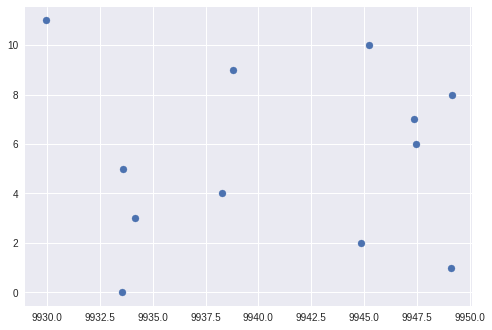

In [29]:
plt.scatter(new_df["score"], range(len(new_df["score"])))

In [30]:
new_df

score
strategy         value             
ctrl             0.0    9933.546382
decay_temp_gene  0.0    9949.140109
decay_temp_param 0.0    9944.862082
number_gene      0.0    9934.143995
sparse_gene      0.1    9938.295146
                 0.3    9933.583117
sparse_param     0.1    9947.441889
                 0.3    9947.378689
temp_gene        0.05   9949.144126
                 0.2    9938.789595
temp_param       0.05   9945.231881
                 0.2    9929.929113

Quick conclusion without stats, it seems that decay is really helpful, lower temperature too (for both genes and params). However, sparse param scores seem contradictory because both lower and higher are better

In [31]:
dict_list = defaultdict(list)

for a, b, _, score in results:
    dict_list[(a, b)].append(score)

In [32]:
from scipy.stats import ttest_ind

In [35]:
all_p = []
for k, v in dict_list.items():
    print("-" * 80)
    print(k)
    print(ttest_ind(v, dict_list[('ctrl', '0.0')]))
    z = ttest_ind(v, dict_list[('ctrl', '0.0')])
    all_p.append(z.pvalue)
    print()

--------------------------------------------------------------------------------
('decay_temp_param', '0.0')
Ttest_indResult(statistic=0.9122467767542309, pvalue=0.38830200295157313)

--------------------------------------------------------------------------------
('ctrl', '0.0')
Ttest_indResult(statistic=0.0, pvalue=1.0)

--------------------------------------------------------------------------------
('temp_param', '0.05')
Ttest_indResult(statistic=0.9668840469173245, pvalue=0.36191856888291285)

--------------------------------------------------------------------------------
('temp_param', '0.2')
Ttest_indResult(statistic=-0.34185419887616464, pvalue=0.7412673995454744)

--------------------------------------------------------------------------------
('sparse_gene', '0.1')
Ttest_indResult(statistic=0.49027548693508466, pvalue=0.6371017356288085)

--------------------------------------------------------------------------------
('temp_gene', '0.2')
Ttest_indResult(statistic=0.36455826

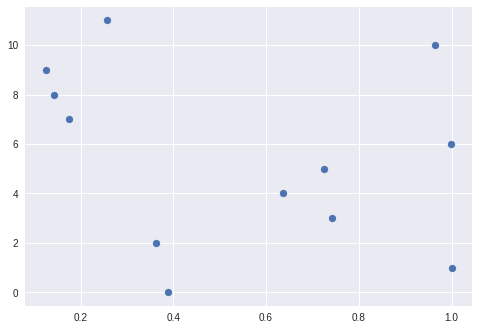

In [38]:
plt.scatter(all_p, range(len(all_p)))